In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append("..")
from modules.BatchPitNormalization import BatchPitNorm1d
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

/tmp/ipykernel_176411/490934269.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


track_genre
world-music          1000
acoustic             1000
show-tunes           1000
singer-songwriter    1000
ska                  1000
                     ... 
anime                1000
black-metal          1000
bluegrass            1000
blues                1000
brazil               1000
Name: count, Length: 114, dtype: int64


<Axes: xlabel='track_genre'>

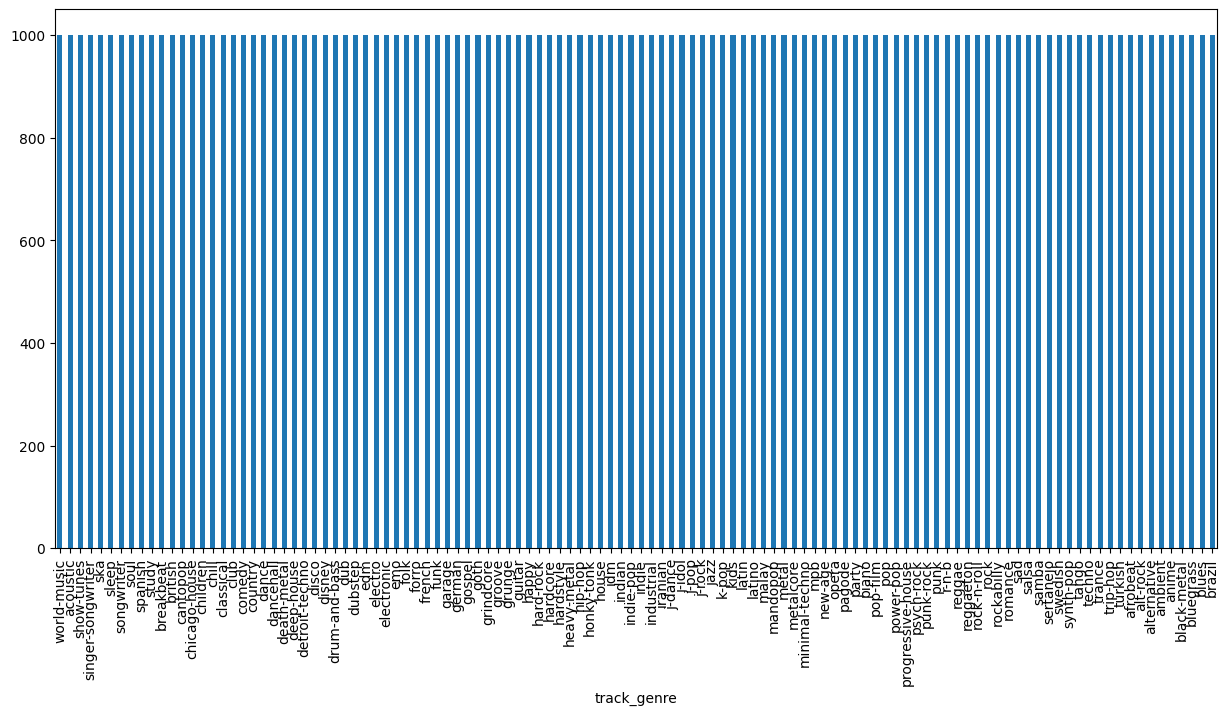

In [2]:
data = pd.read_csv("../data/spotify.csv")
data.head()

count = data["track_genre"].value_counts()
print(count)
plt.figure(figsize=(15,7))
count.plot(kind="bar")

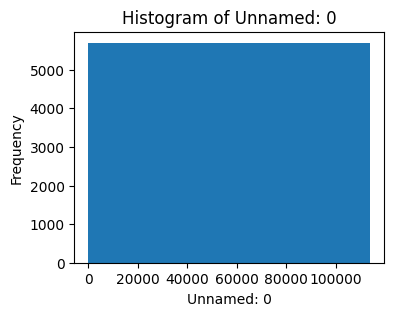

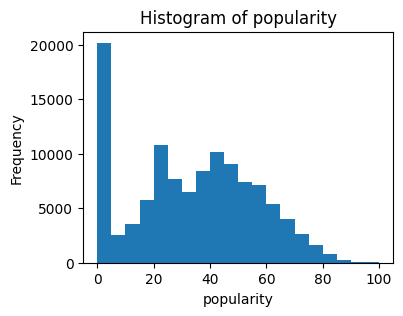

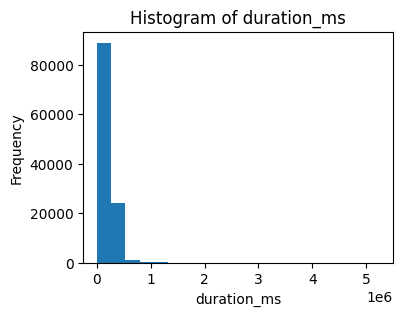

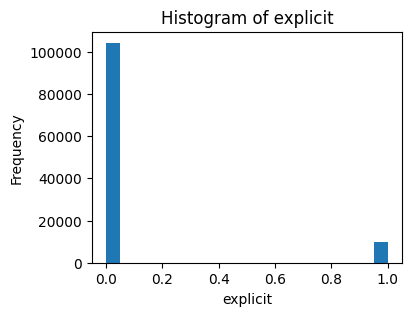

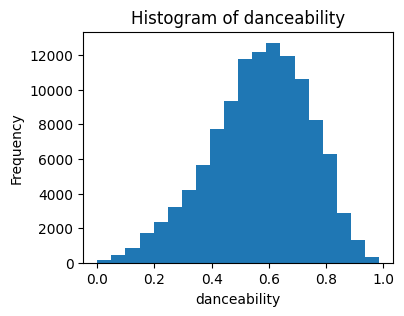

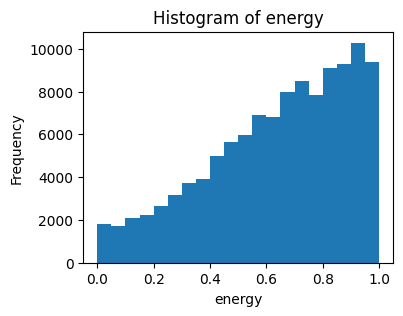

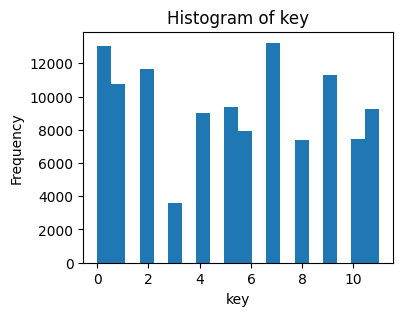

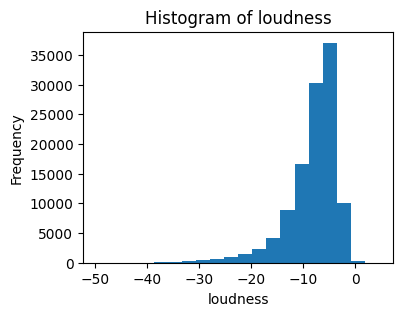

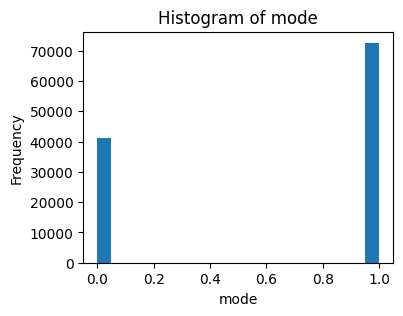

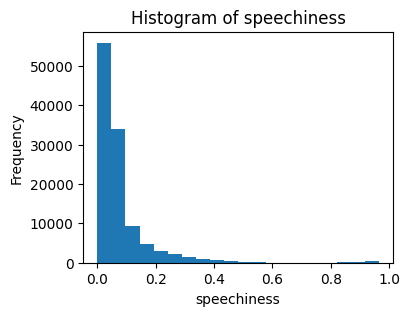

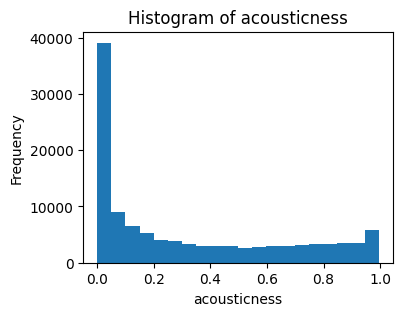

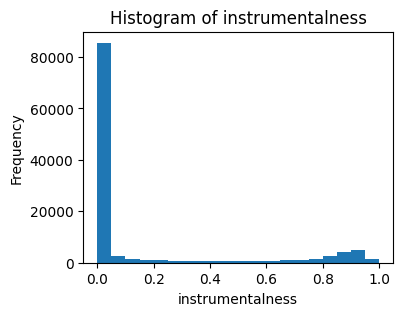

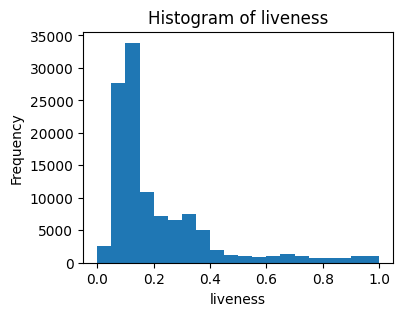

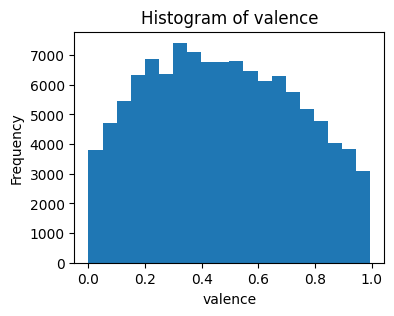

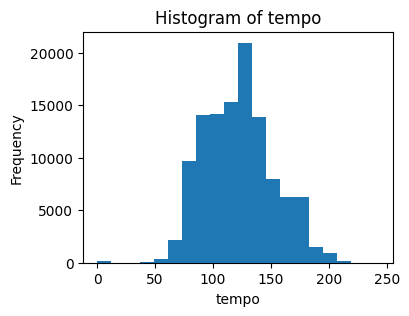

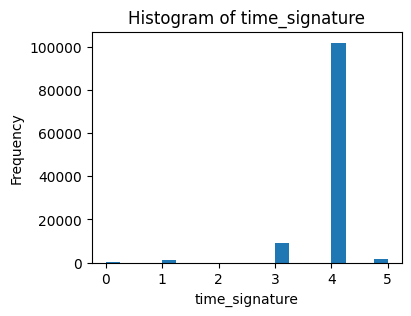

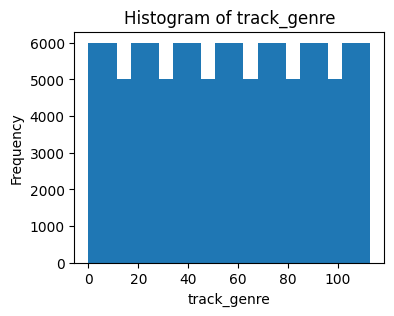

In [10]:
numeric_columns = data.select_dtypes(include=['number']).columns
for column in numeric_columns:
    # Plot the column
    plt.figure(figsize=(4, 3))
    data[column].plot(kind='hist', bins=20)  # You can choose the plot type and adjust bins as needed
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()



In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import torch.utils
import torch.utils.data

missing_values = data.isnull().sum()
#print(missing_values)
# delete nan rows
data.dropna(inplace=True)
data["explicit"] = data["explicit"].astype(int)


le = LabelEncoder()
encoded_column = le.fit_transform(data["track_genre"])
data["track_genre"] = encoded_column


X = data.drop(columns=["track_genre"])
Y = data["track_genre"].to_frame()

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, Y, train_size = 0.7, shuffle = True)

X_train_raw = X_train_raw.drop(columns=["Unnamed: 0", "track_id", "artists", "album_name", "track_name"])
X_test_raw = X_test_raw.drop(columns=["Unnamed: 0", "track_id", "artists", "album_name", "track_name"])


scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

# scale
scaler_x = scalerX.fit(X_train_raw)
scaler_y = scalerY.fit(y_train_raw)

X_train = scaler_x.transform(X_train_raw)
X_test = scaler_x.transform(X_test_raw)


y_train = scaler_y.transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)


X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_raw.values, dtype=torch.float32, device=device).reshape(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_raw.values, dtype=torch.float32, device=device).reshape(-1,1)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [5]:
from torch import nn
#without bn
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [6]:
from torch import nn
#without bn
class NeuralNetwork_bn(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_bn, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
from torch import nn
#without bn
class NeuralNetwork_pit(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_pit, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            BatchPitNorm1d(num_features=hidden_size,num_pit_samples=hidden_size*3,dev=device,take_num_samples_when_full=0),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,num_classes)
        )
 
    def forward(self, x):
        x = self.layers(x)
        return x

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


def train_model(model):
    model = model
    lossfunction = nn.CrossEntropyLoss().to(device=device)
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    n_epochs = 10
    batch_size = 32
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

    for epoch in range(n_epochs):
        running_loss = 0.0
        model.to(device)
        model.train()
        for xbatch, ybatch in train_loader:
            xbatch, ybatch = xbatch.to(device), ybatch.to(device).squeeze()
            y_pred = model(xbatch)

            loss = lossfunction(y_pred, ybatch.long())
            loss.backward(retain_graph=True)
            
            optimizer.step()
            optimizer.zero_grad()
            #print(loss.item())
            running_loss += loss.item()

    model.eval()
    y_pred_eval = model(X_test)
    y_pred_eval = torch.softmax(y_pred_eval, dim=1).argmax(dim=1)
    y_pred_eval = y_pred_eval.detach().cpu().numpy()
    y_test_eval = y_test.detach().cpu().numpy()
    print("accuracy:",round(100*accuracy_score(y_test_eval,y_pred_eval),2),"%")
    print("precision:", round(100*precision_score(y_test_eval,y_pred_eval,average="macro"),2),"%")
    return accuracy_score(y_test_eval,y_pred_eval), precision_score(y_test_eval,y_pred_eval,average="macro")
#models = [NeuralNetwork(15,64,114), NeuralNetwork_bn(15,64,114) ,NeuralNetwork_pit(15,64,114)]

#train_model(NeuralNetwork(15,64,114))


In [11]:
model_1 = NeuralNetwork(15,64,114)
model_2 = NeuralNetwork_bn(15,64,114)
model_3 = NeuralNetwork_pit(15,64,114)

ac1_l,pr1_l = [],[]
ac2_l,pr2_l = [],[]
ac3_l,pr3_l = [],[]
for i in range(3):
    ac1,pr1 = train_model(model_1)
    ac2,pr2 = train_model(model_2)
    ac3,pr3 = train_model(model_3)

    ac1_l.append(ac1)
    pr1_l.append(pr1)
    ac2_l.append(ac2)
    pr2_l.append(pr2)
    ac3_l.append(ac3)
    pr3_l.append(pr3)

    



accuracy: 21.55 %
precision: 22.23 %


/home/ubuntu/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy: 26.19 %
precision: 25.44 %


/home/ubuntu/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/miniconda3/envs/dl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ubuntu/batch-pit-normalization/bpitnorm/sprint6/../modules/BatchPitNormalization.py:103: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::quantile.scalar. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /o

KeyboardInterrupt: 

In [ ]:
plt.boxplot([ac1_l,ac2_l,ac3_l],labels=["no bn","with ordinary bn", "with pit"])
plt.title("Accuracy")
plt.figure()
plt.boxplot([pr1_l,pr2_l,pr3_l],labels=["no bn","with ordinary bn", "with pit"])
plt.title("Precision")
